# Rankability Predicting Sensitivity
## March Madness Dataset

Goal of this notebook is to analyze and visualize the results

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
import os
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import pearsonr
from scipy.stats import skew
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [3]:
from pathlib import Path
home = str(Path.home())
home

'/home/jupyter-pander14'

In [4]:
import sys
sys.path.insert(0,"%s/rankability_toolbox_dev"%home)
import pyrankability

In [5]:
sys.path.insert(0,"%s/sensitivity_study/src"%home)
from sensitivity_tests import *
from utilities import *
from base import *

In [6]:
import itertools
import joblib

In [7]:
problem = joblib.load("/disk/rankability_datasets/sensitivity_study/problem_0002a.joblib.z")

In [8]:
print(problem["description"])


This dataset represents the sensitivity problem as defined as follows:

A practitioner wants to predict the degree to which a season of the NCAA Men’s Basketball 
will be likely to change after the second half of the season is played. This is in the context of a Massey
with a specific set of parameters

direct_thress = [0,1,2]
spread_thress = [0,3,6]
weight_indirects = [0.25,0.5,1.]
domains_ranges = [('all','madness'),('madness','madness')]



In [9]:
problem['target']

Year  direct_thres  spread_thres  weight_indirect  Domain   Range  
2002  0.0           0.0           0.25             all      madness    0.5
                                  0.50             all      madness    0.5
                                  1.00             all      madness    0.5
                    3.0           0.25             all      madness    0.5
                                  0.50             all      madness    0.5
                                                                      ... 
2018  2.0           3.0           0.50             madness  madness    0.5
                                  1.00             madness  madness    0.6
                    6.0           0.25             madness  madness    0.6
                                  0.50             madness  madness    0.5
                                  1.00             madness  madness    0.6
Name: intersection_0.5_to_1.0, Length: 918, dtype: float64

In [10]:
problem['data'].keys()

dict_keys(['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])

In [11]:
problem['data']['2002'].keys()

dict_keys(['frac=0.5', 'frac=0.6', 'frac=0.7', 'frac=0.8', 'frac=0.9', 'frac=1.0'])

In [12]:
problem['target'].to_frame().reset_index()

,Year,direct_thres,spread_thres,weight_indirect,Domain,Range,intersection_0.5_to_1.0
0,2002,0.0,0.0,0.25,all,madness,0.5
1,2002,0.0,0.0,0.50,all,madness,0.5
2,2002,0.0,0.0,1.00,all,madness,0.5
3,2002,0.0,3.0,0.25,all,madness,0.5
4,2002,0.0,3.0,0.50,all,madness,0.5
...,...,...,...,...,...,...,...
913,2018,2.0,3.0,0.50,madness,madness,0.5
914,2018,2.0,3.0,1.00,madness,madness,0.6
915,2018,2.0,6.0,0.25,madness,madness,0.6
916,2018,2.0,6.0,0.50,madness,madness,0.5


In [13]:
def compute(game_df,team_range,direct_thres,spread_thres,weight_indirect):
    hillside_columns = ["direct_thres","spread_thres","weight_indirect","details"]

    map_func = lambda linked: pyrankability.construct.support_map_vectorized_direct_indirect_weighted(linked,direct_thres=direct_thres,spread_thres=spread_thres,weight_indirect=weight_indirect)
    D = pyrankability.construct.V_count_vectorized(game_df,map_func).reindex(index=team_range,columns=team_range)
    k,details = pyrankability.rank.solve(D,method='hillside',lazy=False,cont=True)
    x = pd.DataFrame(details['x'],columns=D.columns,index=D.index)
    c = pd.DataFrame(pyrankability.construct.C_count(D),columns=D.columns,index=D.index)
    P = details['P']
    simple_details = {'k':k,'x':x,'c':c,'P':P,'D':D}
    hillside_ret = pd.Series([direct_thres,spread_thres,weight_indirect,simple_details],index=hillside_columns)
    return hillside_ret


In [14]:
from scipy.stats import pearsonr
from scipy.stats import kendalltau
def score_by_correlation(s,r):
    return pearsonr(s,r)[0]

In [15]:
def calc_score(y,score_by,direct_thres,spread_thres,weight_indirect,domain_range,top_n=10):
    parameter_string = f"{domain_range},dt={direct_thres},st={spread_thres},iw={weight_indirect}"
    values = []
    for year in y.index:
        # set the team_range
        team_range = None
        if domain_range[1] == 'madness':
            team_range = madness_teams[year]
        elif domain_range[1] == 'all':
            team_range = all_teams[year]
        elif "top" in domain_range:
            team_range = all_teams[year]
        
        knorms = []
        for frac_key in ['frac=0.5']:#problem['data'][year].keys():
            hillside_details = compute(problem['data'][year][frac_key],team_range,direct_thres,spread_thres,weight_indirect)
            perm = np.array(hillside_details['details']['P'][0])
            C = hillside_details['details']['c'].iloc[perm,:].iloc[:,perm].iloc[:top_n,:].iloc[:,:top_n]
            n = len(C)
            kmax = (n*n-n)/2 * n
            k = np.sum(np.triu(C))
            knorms.append(k/kmax)
        knorm = np.mean(knorms)
        values.append(knorm)
    return pd.DataFrame([[score_by(values,y),parameter_string]],columns=columns)

In [ ]:
direct_thress = [0,1,2]
spread_thress = [0,3,6]
weight_indirects = [0.25,0.5,1.]
domains_ranges = [('all','madness'),('madness','madness')]

keys = list(itertools.product(direct_thress,spread_thress,weight_indirects,domains_ranges))

test_results = pd.DataFrame(columns=["Score","Parameters"]).set_index('Parameters')
for direct_thres,spread_thres,weight_indirect,domain_range in keys:
    targets = problem['target'].to_frame().reset_index().set_index(['direct_thres','spread_thres','weight_indirect','Domain','Range']).loc[direct_thres,spread_thres,weight_indirect,domain_range[0],domain_range[1]]
    targets = targets.set_index('Year')['intersection_0.5_to_1.0']

    years = list(targets.index)
    remaining_games = problem['other']['remaining_games']
    madness_teams = problem['other']['madness_teams']

    years_train = ['2002','2003','2004','2005','2006']
    years_test = copy.copy(years)
    for year in years_train:
        years_test.remove(year)

    test_results1 = calc_score(targets.loc[years_test],score_by_correlation,direct_thres,spread_thres,weight_indirect,domain_range)
    test_results = test_results.append(test_results1.set_index('Parameters'))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/opt/tljh/user/lib/python

In [23]:
test_results

,Score
Parameters,
"('all', 'madness'),dt=0,st=0,iw=0.25",-0.023307
"('madness', 'madness'),dt=0,st=0,iw=0.25",0.252993
"('all', 'madness'),dt=0,st=0,iw=0.5",0.220929
"('madness', 'madness'),dt=0,st=0,iw=0.5",0.115073
"('all', 'madness'),dt=0,st=0,iw=1.0",0.367021
"('madness', 'madness'),dt=0,st=0,iw=1.0",-0.239322
"('all', 'madness'),dt=0,st=3,iw=0.25",-0.023307
"('madness', 'madness'),dt=0,st=3,iw=0.25",0.252993
"('all', 'madness'),dt=0,st=3,iw=0.5",0.220929


<AxesSubplot:ylabel='Frequency'>

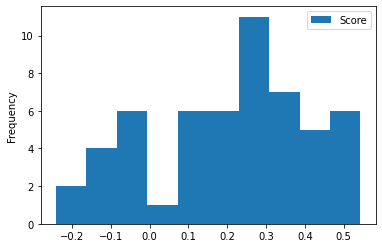

In [24]:
test_results.plot.hist()

In [26]:
test_results.sort_values(by="Score")

,Score
Parameters,
"('madness', 'madness'),dt=0,st=3,iw=1.0",-0.241296
"('madness', 'madness'),dt=0,st=0,iw=1.0",-0.239322
"('madness', 'madness'),dt=1,st=3,iw=1.0",-0.155862
"('madness', 'madness'),dt=0,st=6,iw=1.0",-0.146016
"('madness', 'madness'),dt=2,st=0,iw=0.5",-0.125552
"('madness', 'madness'),dt=1,st=0,iw=1.0",-0.118634
"('madness', 'madness'),dt=2,st=3,iw=0.5",-0.066471
"('madness', 'madness'),dt=1,st=6,iw=1.0",-0.061918
"('all', 'madness'),dt=0,st=6,iw=0.25",-0.055705
